# Video prediction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.model_zoo import load_url
import matplotlib.pyplot as plt
from scipy.special import expit

import sys
sys.path.append('..')

from blazeface.face_extract import FaceExtractor
from blazeface.blazeface import BlazeFace
from blazeface.read_video import VideoReader

from architectures import fornet
from isplutils import utils

In [ ]:
net_model = 'EfficientNetB4'
train_db = 'FFPP'

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
face_size = 224
frames_per_video = 32

In [ ]:
model_path = "/content/drive/MyDrive/KLTN/model_v15/net-EfficientNetB4_traindb-ff-c23-720-140-140_face-scale_size-224_seed-41/bestval.pth"
net = getattr(fornet, net_model)().eval().to(device)
checkpoint = torch.load(model_path, map_location=device)
net.load_state_dict(checkpoint['net'])

Loaded pretrained weights for efficientnet-b4


<All keys matched successfully>

In [ ]:
transf = utils.get_transformer(face_size, net.get_normalizer(), train=False)

/content/KLTN/isplutils/utils.py:102: UserWarning: Argument(s) 'value, always_apply' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=patch_size, min_width=patch_size,
/content/KLTN/isplutils/utils.py:104: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=patch_size, width=patch_size, always_apply=True),


In [ ]:
facedet = BlazeFace().to(device)
facedet.load_weights("../blazeface/blazeface.pth")
facedet.load_anchors("../blazeface/anchors.npy")
videoreader = VideoReader(verbose=False)
video_read_fn = lambda x: videoreader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn=video_read_fn,facedet=facedet)

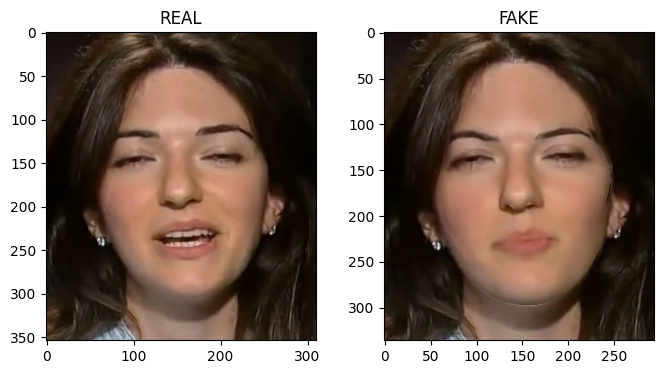

In [ ]:
vid_real_faces = face_extractor.process_video('/content/drive/MyDrive/KLTN/datasets/original_sequences/youtube/c23/videos/585.mp4')
vid_fake_faces = face_extractor.process_video('/content/drive/MyDrive/KLTN/datasets/manipulated_sequences/Face2Face/c23/videos/585_599.mp4')
im_real_face = vid_real_faces[0]['faces'][0]
im_fake_face = vid_fake_faces[0]['faces'][0]
fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(im_real_face)
ax[0].set_title('REAL')

ax[1].imshow(im_fake_face)
ax[1].set_title('FAKE');

[AUC]        : 0.8293
[Best thr]   : 0.5891
[Accuracy]   : 0.7425


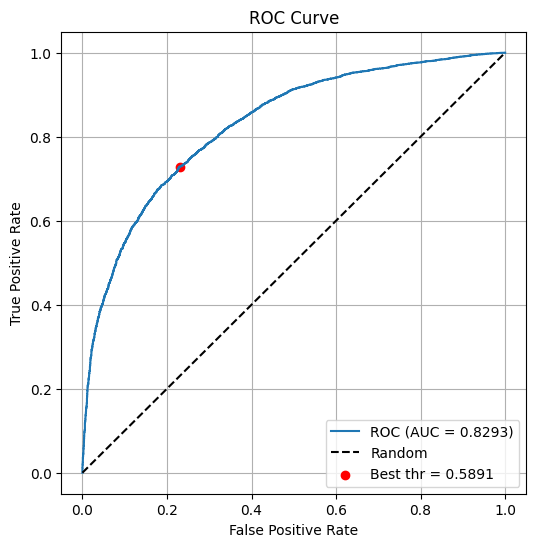

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
from scipy.special import expit  # sigmoid

PKL_PATH = "/content/drive/MyDrive/KLTN/result_v15/net-EfficientNetB4_traindb-ff-c23-720-140-140_face-scale_size-224_seed-41_bestval/ff-c23-720-140-140_test.pkl"

df = pd.read_pickle(PKL_PATH)
y_true = df['label'].astype(int).values

y_logit = df['score'].values
y_score = expit(y_logit)

auc = roc_auc_score(y_true, y_score)

fpr, tpr, thresholds = roc_curve(y_true, y_score)
youden_index = tpr - fpr
best_idx = np.argmax(youden_index)
best_threshold = thresholds[best_idx]

y_pred = (y_score >= best_threshold).astype(int)
acc = accuracy_score(y_true, y_pred)

print(f"[AUC]        : {auc:.4f}")
print(f"[Best thr]   : {best_threshold:.4f}")
print(f"[Accuracy]   : {acc:.4f}")

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f"Best thr = {best_threshold:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


Average score for REAL video: 0.0887 --> Predicted: REAL
Average score for FAKE video: 0.8248 --> Predicted: FAKE


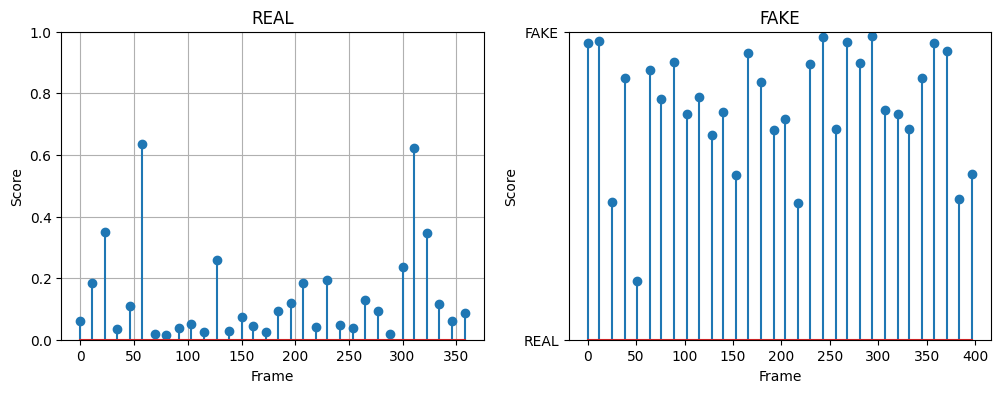

In [ ]:
faces_real_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_real_faces if len(frame['faces'])] )
faces_fake_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_fake_faces if len(frame['faces'])] )

with torch.no_grad():
    faces_real_pred = net(faces_real_t.to(device)).cpu().numpy().flatten()
    faces_fake_pred = net(faces_fake_t.to(device)).cpu().numpy().flatten()
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].stem(
    [f['frame_idx'] for f in vid_real_faces if len(f['faces'])],
    expit(faces_real_pred)
)
ax[0].set_title('REAL')
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Score')
ax[0].set_ylim([0, 1])
ax[0].grid(True)

ax[1].stem(
    [f['frame_idx'] for f in vid_fake_faces if len(f['faces'])],
    expit(faces_fake_pred)
)
ax[1].set_title('FAKE')
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Score')
ax[1].set_ylim([0, 1])
ax[1].set_yticks([0, 1], ['REAL', 'FAKE'])
score_real_avg = expit(faces_real_pred.mean())
score_fake_avg = expit(faces_fake_pred.mean())
pred_real_video = 'FAKE' if score_real_avg >= best_threshold else 'REAL'
pred_fake_video = 'FAKE' if score_fake_avg >= best_threshold else 'REAL'

print('Average score for REAL video: {:.4f} --> Predicted: {}'.format(score_real_avg, pred_real_video))
print('Average score for FAKE video: {:.4f} --> Predicted: {}'.format(score_fake_avg, pred_fake_video))
